# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [113]:
from __future__ import division
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from sklearn.cluster import KMeans 
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
import cv2

from collections import deque

In [114]:
## Google Credentials

### AMIT - Imports for Vision API
# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

## Env setup

## Object detection imports
Here are the imports from the object detection module.

In [115]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [116]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/home/priya/Documents/seattle_sports/detection/faster_rcnn_inception_v2_coco_2018_01_28' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/' + 'mscoco_label_map.pbtxt'

NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [117]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [118]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [119]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection

In [120]:
def detect_videos(image_np, sess, detection_graph):
    
    with detection_graph.as_default():
        
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
          ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
        if 'detection_masks' in tensor_dict:
            # The following processing is only for single image
            detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
            detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
            # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
            real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
            detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
            detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
            detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
            detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
            # Follow the convention by adding back the batch dimension
            tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
        output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image_np, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]

        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          min_score_thresh = 0.85,
          use_normalized_coordinates=True,
          line_thickness=3)
        
        
#         objects = {}
#         for n in range(len(output_dict['detection_scores'])):
#             if  output_dict['detection_scores'][n] > 0.80: 

#                  # Find label corresponding to that class
#                 for cat in categories:
#                     if cat['id'] == output_dict['detection_classes'][n]:
#                         label = cat['name']

#                 if label in objects:
#                     objects[label] += 1
#                 else:
#                     objects[label] = 1
#         i=0            
#         for key in objects.keys():
#             i += 1
#             text_pos = key + " : " + str(objects[key])
#             cv2.putText(image_np, text_pos, (20, 40 * i), cv2.FONT_HERSHEY_COMPLEX, 0.80, (255, 255, 255), 2)

#         print(objects)        
    return image_np, output_dict

In [121]:
filename = '/home/priya/Documents/seattle_sports/detection/CLIP0000196.mov'
out_filename = 'CLIP0000196.mov_out_jersey' + ".avi"

cap = cv2.VideoCapture(filename)
vwriter = cv2.VideoWriter(out_filename,cv2.VideoWriter_fourcc(*'MJPG'),20, (1024, 600)) 

frame_counter = 0
kmeans_counter = 0
fac = 5
threshold = 1000
X = deque(maxlen=threshold)
avg_height= 180  
avg_width=  90
trained = False
CROPPED_SIZE = (8, 12)

In [122]:
def add_to_queue(X, image_np, location_int):
    for i,loc in enumerate(location_int):
        sliced = image_np[loc[0]:loc[2],loc[1]:loc[3]].copy()
        resized = cv2.resize(sliced, (avg_width,avg_height), interpolation=cv2.INTER_AREA)
        X.append(resized)
    return X

In [123]:
### AMIT - This is the function to call the API
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    content = path
    image = vision.types.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    read_text = []
    #print('Texts:')

    for text in texts:
        read_text.append(text.description)

        #vertices = (['({},{})'.format(vertex.x, vertex.y)
        #            for vertex in text.bounding_poly.vertices])

        #print('bounds: {}'.format(','.join(vertices)))
        
    return read_text

CROPPING VISUALIZATION:


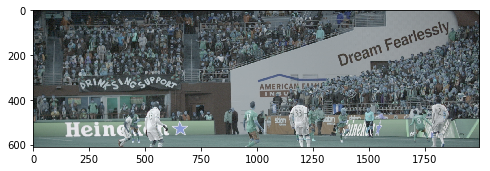

Read Text:  ['Dream Fearlessly\nAMERICAN EA\nINSU\nHeinet\n', 'Dream', 'Fearlessly', 'AMERICAN', 'EA', 'INSU', 'Heinet']
CROPPING VISUALIZATION:


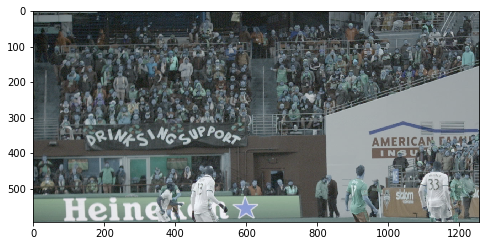

Read Text:  ['AMERICAN EA?\nINSU\nsdom\n', 'AMERICAN', 'EA?', 'INSU', 'sdom']
CROPPING VISUALIZATION:


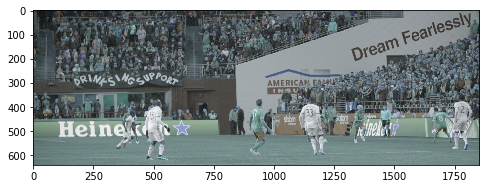

Read Text:  ['Dream Fearlessly\nAMERICAN EAAR\nHeineK\n', 'Dream', 'Fearlessly', 'AMERICAN', 'EAAR', 'HeineK']
CROPPING VISUALIZATION:


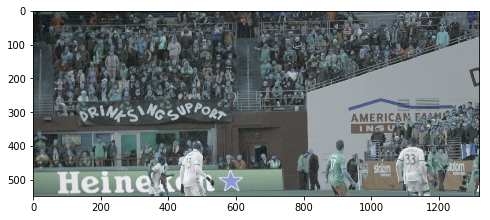

Read Text:  ['AMERICAN EA\nINSU\nHeinek\n', 'AMERICAN', 'EA', 'INSU', 'Heinek']
CROPPING VISUALIZATION:


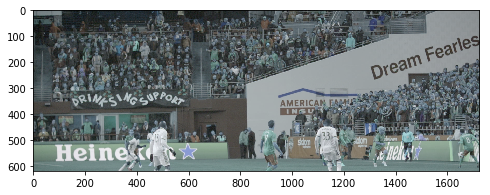

Read Text:  ['Dream Fearles\nAMERICAN\nINSU\nHeineK\n', 'Dream', 'Fearles', 'AMERICAN', 'INSU', 'HeineK']
CROPPING VISUALIZATION:


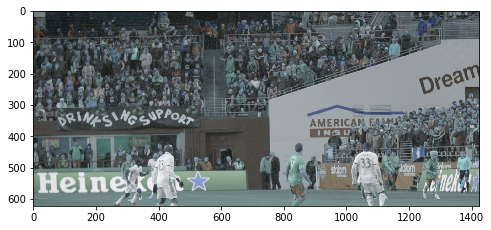

Read Text:  ['าว่\nDream\nAMERICAN EA\nHeine\nIT\n', 'า', 'ว่', 'Dream', 'AMERICAN', 'EA', 'Heine', 'IT']


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7f65e190b7f0>" raised exception!
Traceback (most recent call last):
  File "/home/priya/miniconda3/envs/tf_latest/lib/python3.6/site-packages/grpc/_plugin_wrapping.py", line 80, in __call__
  File "/home/priya/miniconda3/envs/tf_latest/lib/python3.6/site-packages/google/auth/transport/grpc.py", line 77, in __call__
  File "/home/priya/miniconda3/envs/tf_latest/lib/python3.6/site-packages/google/auth/transport/grpc.py", line 65, in _get_authorization_headers
  File "/home/priya/miniconda3/envs/tf_latest/lib/python3.6/site-packages/google/auth/credentials.py", line 122, in before_request
  File "/home/priya/miniconda3/envs/tf_latest/lib/python3.6/site-packages/google/oauth2/service_account.py", line 322, in refresh
  File "/home/priya/miniconda3/envs/tf_latest/lib/python3.6/site-packages/google/oauth2/_client.py", line 145, in jwt_grant
  File "/home/priya/miniconda3/envs/tf

KeyboardInterrupt: 

Exception ignored in: 'grpc._cython.cygrpc._next'
KeyboardInterrupt


KeyError: None

In [124]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

        while True:
            ret, image_np = cap.read()
#             print(image_np.shape)
            if not ret:
                break

            new_width = 1024
            new_height = 600
            image_np = cv2.resize(image_np, (new_width,new_height), interpolation=cv2.INTER_AREA)
            orig_image = image_np.copy()
            
            if frame_counter % fac == 0:
                image_np, output_dict = detect_videos(image_np, sess, detection_graph)
                location_int = []
                
                for n in range(len(output_dict['detection_scores'])):
                    if output_dict['detection_scores'][n] > 0.85 and output_dict['detection_classes'][n] == 1: 
                        
                        for cat in categories:
                            if cat['id'] == output_dict['detection_classes'][n]:
                                label = cat['name']
                                #print(label) - Sanity check only looking at person class 
                        
                        ## Store coordinates
                        ans = []
                        ymin = int(output_dict['detection_boxes'][n][0] * new_height)
                        ans.append(ymin)
                        xmin = int(output_dict['detection_boxes'][n][1] * new_width)
                        ans.append(xmin)
                        ymax = int(output_dict['detection_boxes'][n][2] * new_height)
                        ans.append(ymax)
                        xmax = int(output_dict['detection_boxes'][n][3] * new_width)
                        ans.append(xmax)

                        location_int.append(ans)
                        
                        # AMIT - Image is cropped, converted to string and passed to Vision API
                        if ymax-ymin >= 5 and xmax - xmin >=5:
                            crop_img = orig_image[ymin-2:ymax+2, xmin-2:xmax+2]
                            
                            
                            img_str = cv2.imencode('.jpg', crop_img)[1].tostring()
                            read_text = detect_text(img_str) 
                            if len(read_text) > 0:
                                # For debugging
                                print("CROPPING VISUALIZATION:")          
                                plt.figure(figsize=CROPPED_SIZE)
                                plt.imshow(crop_img)
                                plt.show()
                                print("Read Text: ", read_text)
                        
                if not trained:
                    if len(X) < threshold:
                        X = add_to_queue(X, image_np, location_int)
                    elif len(X) >= threshold:
                        X = np.array(X)
                        X_flat = X.reshape(X.shape[0],-1)
                        kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++', n_init=15).fit(X_flat)
                        trained = True
                        print("Queue Length and Trained: ", len(X) , trained)
                    
                if trained:
                    Y = []
                    Y = add_to_queue(Y, image_np, location_int)
                    Y = np.array(Y)
                    Y_flat = Y.reshape(Y.shape[0],-1)
                    pred = kmeans.predict(Y_flat)
                    print(pred)
                
                    for n in range(len(pred)):
                        text_pos = "Team " + str(pred[n])
                        cv2.putText(image_np, text_pos, (location_int[n][1]-10,location_int[n][0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)

        
            frame_counter += 1
            vwriter.write(image_np)
                
        cv2.destroyAllWindows()
        cap.release()